In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import sys
from collections import OrderedDict

sys.path.append('../music-processing-experiments')

from time_intervals import block_labels
from analysis import split_block_times

In [294]:
# let's generate some segments represented by their start time
def segments_from_events(event_times, labels=None):
    """Create a DataFrame with adjacent segments from a list of border events."""
    segments = pd.DataFrame({'start': event_times[:-1], 'end': event_times[1:]})
    segments['duration'] = segments['end'] - segments['start']
    segments = segments[['start', 'end', 'duration']]
    if labels != None:
        assert(len(event_times) == len(labels) + 1)
        segments['label'] = labels
    return segments

def events_from_segments(segments):
    """Create a list of border events DataFrame with adjacent segments."""
    return np.hstack([segments['start'], segments['end'].iloc[-1]])

def generate_segments(size, seed=0):
    np.random.seed(seed)
    event_times = np.random.normal(loc=1, scale=0.25, size=size+1).cumsum()
    event_times = event_times - event_times[0]
    return segments_from_events(event_times, np.random.randint(4, size=size))

In [533]:
segments = generate_segments(20)
segments.head()

/Users/bzamecnik/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


,start,end,duration,label
0,0.000000,1.100039,1.100039,3
1,1.100039,2.344724,1.244684,2
2,2.344724,3.904947,1.560223,3
3,3.904947,5.371837,1.466889,2
4,5.371837,6.127517,0.755681,3


In [285]:
events_from_segments(segments)

array([  0.        ,   1.1000393 ,   2.3447238 ,   3.9049471 ,
         5.3718366 ,   6.12751713,   7.36503923,   8.32719993,
         9.30139521,  10.40404484,  11.44005573,  12.80362411,
        13.99388354,  15.0243023 ,  16.1352681 ,  17.21868669,
        18.59220645,  19.54091689,  20.61918381,  21.40565988,  21.76741242])

In [286]:
def plot_segments(segments, seed=42):
    size = len(segments)
    np.random.seed(seed)
    if 'label' not in segments.columns:
        colors = np.random.permutation(size) / size
    else:
        labels = segments['label']
        unique_labels = sorted(set(segments['label']))
        color_by_label = dict([(l, i) for (i, l) in enumerate(unique_labels)])
        norm_factor = 1.0 / len(unique_labels)
        colors = labels.apply(lambda l: color_by_label[l] * norm_factor)
    plt.figure(figsize=(20,5))
    plt.bar(segments['start'], np.ones(size), width=segments['duration'], color=cm.jet(colors), alpha=0.5)
    plt.xlim(0, segments['end'].iloc[-1])
    plt.xlabel('time')
    plt.yticks([]);

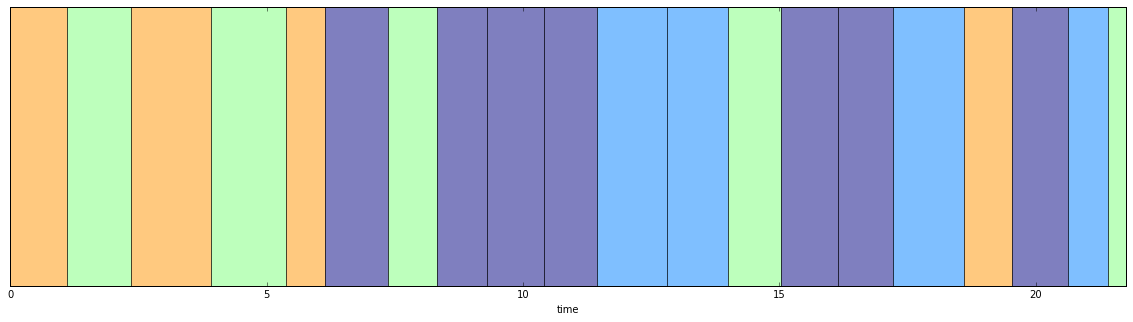

In [282]:
plot_segments(segments)

In [191]:
def make_blocks(total_duration, block_duration):
    return segments_from_events(np.arange(0, total_duration, block_duration))

In [531]:
total_duration = segments.iloc[-1]['end']
print('total duration:', total_duration)
blocks = make_blocks(total_duration, 0.25)
print('number of blocks:', len(blocks))
blocks.head()

total duration: 21.7674124243
number of blocks: 87


,start,end,duration
0,0.00,0.25,0.25
1,0.25,0.50,0.25
2,0.50,0.75,0.25
3,0.75,1.00,0.25
4,1.00,1.25,0.25


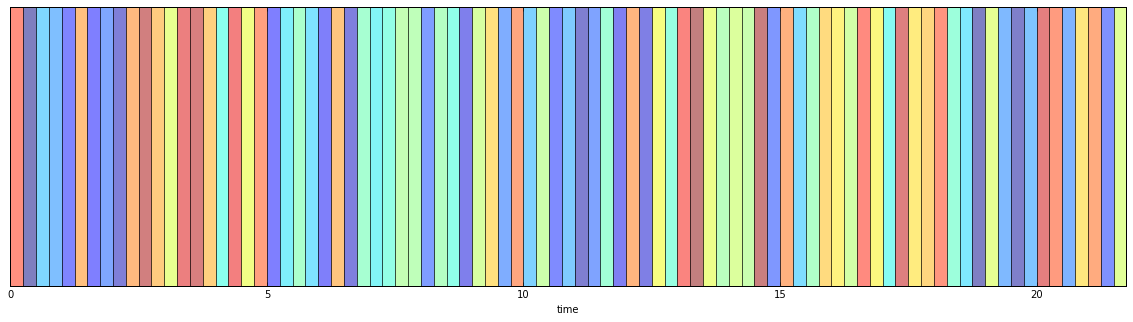

In [193]:
plot_segments(blocks)

# Representation of events

- just a list of start times + label, sentinel at the end
  - (+) easy to merge
  - (-) needs a sentinel
- list of segments with start & end times and label
  - (+) provided eg. in the Isophonics dataset
  - (+) easy to reason about and visualize
  - (-) harder to merge

In [516]:
class Events():
    def __init__(self, start_times, labels):
        """last item must be sentinel with no label"""
        assert(len(labels) >= len(start_times) - 1)
        if len(labels) < len(start_times):
            labels = labels.append(pd.Series([np.nan]))
        self._df = pd.DataFrame({'start': start_times, 'label': labels}, columns=['start', 'label'])
    def df(self):
        return self._df
    
class Segments():
    def __init__(self, start_times, labels):
        """last item must be sentinel with NaN label"""
        self._df = segments_from_events(start_times, labels)

    def df(self):
        return self._df
    
    def join(self, other):
        sentinel_value = '_END_'
        def add_sentinel(df):
            last_event = df[-1:]
            return df.append(pd.DataFrame({
                'start': last_event['end'],
                'end': last_event['end'],
                'duration': 0.0,
                'label': sentinel_value
            }, columns=last_event.columns))
        def remove_sentinel(df, cols):
            for col in cols:
                df[col] = df[col].apply(lambda v: np.nan if v == sentinel_value else v)
        self_df = add_sentinel(self.df())[['start', 'label']].set_index('start')
        other_df = add_sentinel(other.df())[['start', 'label']].set_index('start')
        joined_df = self_df.join(other_df, lsuffix='_left', rsuffix='_right', how='outer')
        joined_df.fillna(method='ffill', inplace=True)
        remove_sentinel(joined_df, ['label_right', 'label_left'])
        joined_df['label_equals'] = joined_df['label_left'] == joined_df['label_right']
        joined_df.reset_index(inplace=True)
        joined_df['end'] = joined_df['start'].shift(-1)
        joined_df['duration'] = joined_df['end'] - joined_df['start']
        joined_df = joined_df[:-1]
        return joined_df #Segments(joined_df['start'], joined_df['label'])

In [517]:
annotations = Segments(np.array([0, 1, 2, 3, 3.5, 4]), ['A','B','A','C','A'])
annotations.df()

,start,end,duration,label
0,0.0,1.0,1.0,A
1,1.0,2.0,1.0,B
2,2.0,3.0,1.0,A
3,3.0,3.5,0.5,C
4,3.5,4.0,0.5,A


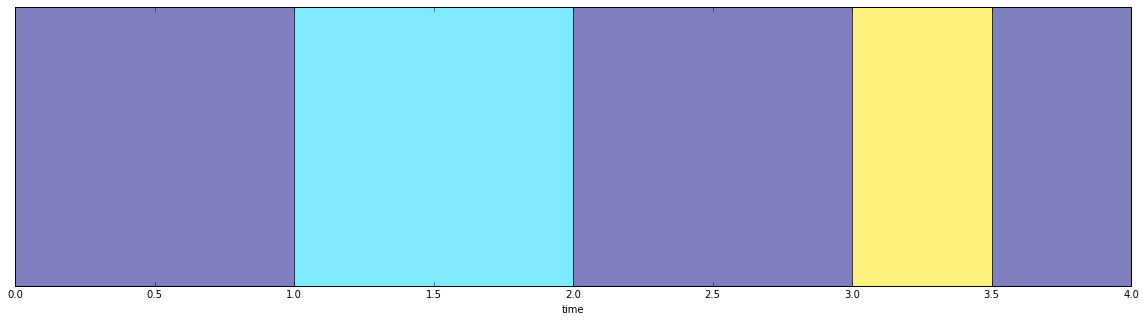

In [518]:
plot_segments(annotations.df())

In [519]:
estimations = Segments(np.array([0, 0.9, 1.8, 2.5, 3.1, 3.4, 4.5]), ['A','B','A','B','C','A'])
estimations.df()

,start,end,duration,label
0,0.0,0.9,0.9,A
1,0.9,1.8,0.9,B
2,1.8,2.5,0.7,A
3,2.5,3.1,0.6,B
4,3.1,3.4,0.3,C
5,3.4,4.5,1.1,A


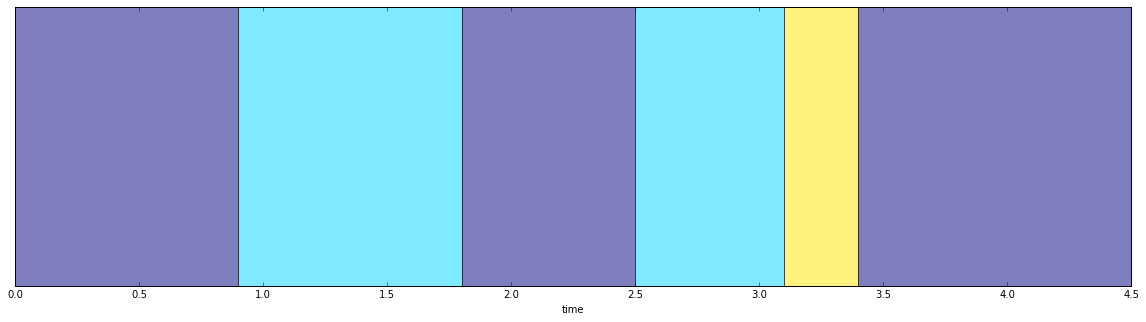

In [396]:
plot_segments(estimations.df())

In [ ]:
def join_segments(df1, df2):
    """Joins two dataframes with segments into a single one (ignoring labels)"""
    np.hstack(events_from_segments(df1), events_from_segments(df1))

In [222]:
events = np.hstack([events_from_segments(annotations), events_from_segments(estimations)])
events.sort()
events = np.unique(events)
events

array([ 0. ,  0.9,  1. ,  1.8,  2. ,  2.5,  3. ,  3.1,  3.4,  3.5,  4. ,
        4.5])

In [225]:
merged = segments_from_events(events)
merged

,start,end,duration
0,0.0,0.9,0.9
1,0.9,1.0,0.1
2,1.0,1.8,0.8
3,1.8,2.0,0.2
4,2.0,2.5,0.5
5,2.5,3.0,0.5
6,3.0,3.1,0.1
7,3.1,3.4,0.3
8,3.4,3.5,0.1
9,3.5,4.0,0.5


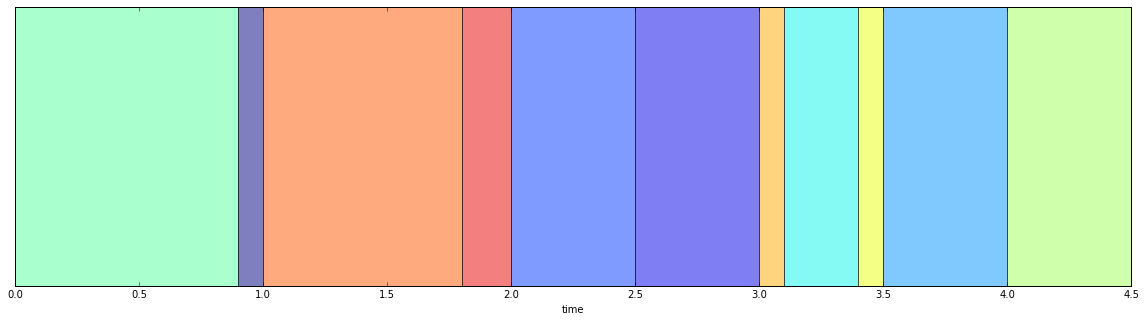

In [244]:
plot_segments(merged)

In [522]:
merged_df = annotations.join(estimations)
merged_df

,start,label_left,label_right,label_equals,end,duration
0,0.0,A,A,True,0.9,0.9
1,0.9,A,B,False,1.0,0.1
2,1.0,B,B,True,1.8,0.8
3,1.8,B,A,False,2.0,0.2
4,2.0,A,A,True,2.5,0.5
5,2.5,A,B,False,3.0,0.5
6,3.0,C,B,False,3.1,0.1
7,3.1,C,C,True,3.4,0.3
8,3.4,C,A,False,3.5,0.1
9,3.5,A,A,True,4.0,0.5


# [Weighted] Chord Symbol Recall

```
CSR = D_equals / D_annot
```

- `CSR` - chord symbol recall (for a single song)
- `D_equals` - total duration of segments where annotation equals estimation
- `D_annot` - total duration of annotated segments

```
WSCR = sum(D_annot[i] * CSR[i])
```

- `WSCR` - weighted CSR - average of CSR across songs weighted by song durations

In [529]:
def chord_symbol_recall(pred_segments, true_segments):
    merged_df = pred_segments.join(true_segments)
    return merged_df[merged_df['label_equals']]['duration'].sum() / merged_df['duration'].sum()

In [530]:
chord_symbol_recall(estimations, annotations)

0.6666666666666666

# Blocks to segments

- merge adjacent blocks with same labels into segments